In [1]:
import numpy as np 
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import os
import xml.dom.minidom
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

Populating the interactive namespace from numpy and matplotlib


In [4]:
height , width = 512 , 512 #size to which input image needs to resize

def mapping(file_path):

  table_path = tf.strings.regex_replace(file_path, 'images', 'table_mask')
  # cell_path = tf.strings.regex_replace(file_path, 'FinTabNet_data', 'cell_mask')

  # table_path = tf.strings.regex_replace(table_path, '.jpeg', '.bmp_table.jpeg')
  # cell_path = tf.strings.regex_replace(cell_path, '.jpeg', '.bmp_col.jpeg')
  

  #reading  , resizing and normalizing for image data
  images = tf.io.read_file(file_path)
  images = tf.image.decode_jpeg(images, channels=3) #Decode a JPEG-encoded image to a uint8 tensor
  images = tf.image.resize(images , [height,width])
  images = tf.cast(images, tf.float32) / 255.0 # normalizing image

  #reading  , resizing and normalizing for table mask data
  table_mask = tf.io.read_file(table_path)
  table_mask = tf.image.decode_jpeg(table_mask, channels=1) 
  table_mask = tf.image.resize(table_mask, [height, width]) #resizing image to input shape of model
  table_mask = tf.cast(table_mask, tf.float32) / 255.0 

  # #reading  , resizing and normalizing for cell mask data
  # cell_mask = tf.io.read_file(cell_path)
  # cell_mask = tf.image.decode_jpeg(cell_mask, channels=1) 
  # cell_mask = tf.image.resize(cell_mask, [height, width]) 
  # cell_mask = tf.cast(cell_mask, tf.float32) / 255.0 

  return images, {"table_mask" : table_mask,
                  # "cell_mask" : cell_mask 
                  }

def data_pipeline(dataset, input , batch_size = 1):
  #how many parallel call need to be done , so left tensor to decide
  autotune = tf.data.experimental.AUTOTUNE

  # autotune = 1
  # print(autotune)
  total_size = len(list(dataset))
  dataset = dataset.take(int(0.4*total_size))
  dataset = dataset.shuffle(total_size)
  if input == 'train':
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train 
    proportion = 0.8
    input_data_size = int(proportion * total_size)
    print(input_data_size)
    
    #fetching data for input
    input_data = dataset.take(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    train_data = input_data

    #kepping track of inital loaded data in the memory to speed up the the process for next iteration 
    input_data = input_data.cache()

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size # randomly samples elements from this buffer, replacing the selected elements with new elements
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    # to re-initialize the input_data
    input_data = input_data.repeat()

    #delivers data for the next step before the current step has finished
    input_data = input_data.prefetch(buffer_size=autotune)

    return input_data , train_data

  else:
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train and test
    proportion = 0.8
    input_data_size = int(proportion * total_size)
    print(input_data_size)
    
    #fetching data for input
    input_data = dataset.skip(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    test_data = input_data

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size 
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    return input_data , test_data

In [5]:
#Create a source dataset from given  input data
#dataset = tf.data.Dataset.list_files("/content/content/Shareddrives/my_drive/input/CHK1/data/marmots_1024/*.jpeg")
dataset = tf.data.Dataset.list_files("/content/drive/MyDrive/Fintab/Fintab_test_data/images/*.jpg")

train_dataloader , train_data = data_pipeline(dataset, 'train' , batch_size = 1)
test_dataloader , test_data= data_pipeline(dataset, 'test' , batch_size = 1)

1847
1847


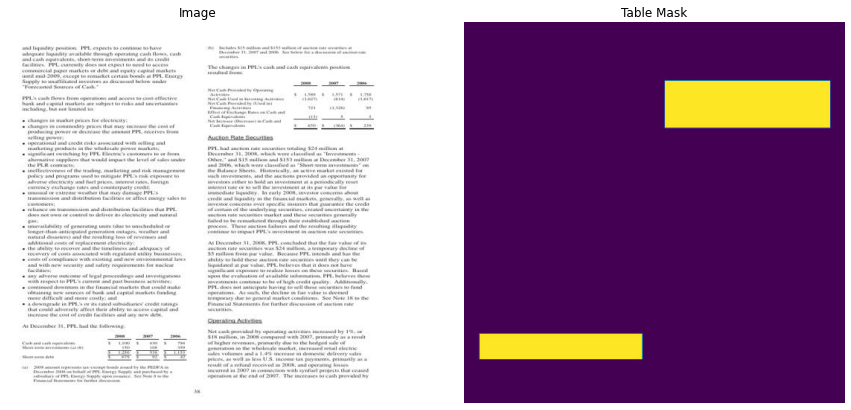

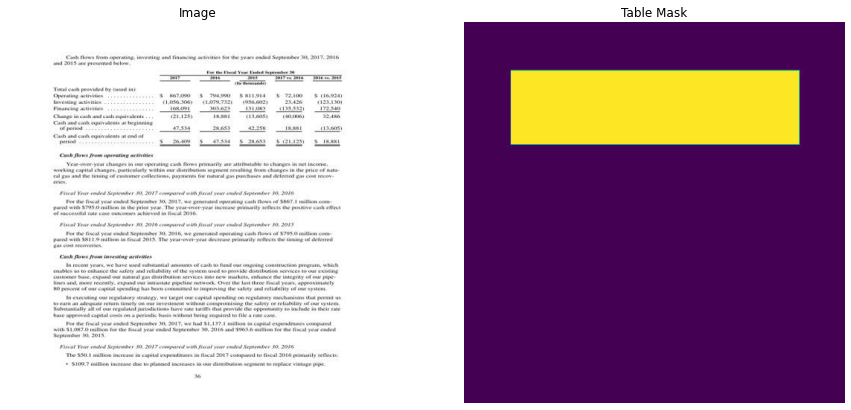

In [6]:
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(15, 15))
  lists = [image, mask['table_mask'], 
          #  mask['cell_mask']
           ]
  title = ['Image', 'Table Mask',
          #  'cell Mask'
           ]         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()   

In [7]:
#input size for all image should be 1024 * 1024 with three channels
inputShape = (height, width, 3)
inputs = Input(shape=inputShape, name='input')

#importing  pre trained VGG19 model till to bottle neck
vgg_19=tf.keras.applications.VGG19(input_tensor=inputs,include_top=False, weights='imagenet', pooling=None, classes=1000)

#addding 2 (1 * 1) convolutional layers followed by dropot eith 80%
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(vgg_19.output)
x = Dropout(0.8, name='block6_dropout1')(x)
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
x = Dropout(0.8, name = 'block6_dropout2')(x)

# for layer in vgg_19.layers:
#     layer.trainable = False

#taking 3rd and 4th maxpool layer from vgg_19 for decoders
block3_pool=vgg_19.get_layer('block3_pool').output
block4_pool=vgg_19.get_layer('block4_pool').output

80150528/80134624 [==============================] - 1s 0us/step


In [8]:
class table_decoder(tf.keras.layers.Layer):
    def __init__(self, name="table_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same')

        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]


      result = self.conv1(input)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.convtraspose(result)

      return result

In [9]:
# class cell_decoder(tf.keras.layers.Layer):
#     def __init__(self, name="cell_mask"):
#         super().__init__(name=name)
#         self.conv1 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
#         self.drop = Dropout(0.8)
#         self.conv2 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
#         self.upsample1 = UpSampling2D(size=(2, 2))
#         self.upsample2 = UpSampling2D(size=(2, 2))
#         self.upsample3 = UpSampling2D(size=(2,2))
#         self.upsample4 = UpSampling2D(size=(2,2))
#         self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same', name='cell_mask')
        
#     def call(self, X):
#       input , pool_3, pool_4 = X[0] , X[1], X[2]

#       result = self.conv1(input)
#       result = self.drop(result)
#       result = self.conv2(result)
#       result = self.upsample1(result)
#       result = Concatenate()([result,pool_4])
#       result = self.upsample2(result)
#       result = Concatenate()([result,pool_3])
#       result = self.upsample3(result)
#       result = self.upsample4(result)
#       result = self.convtraspose(result)
#       return result

In [10]:
encoder_result = [x,block3_pool,block4_pool]

Table_Decoder = table_decoder()
# cell_Decoder = cell_decoder()

output1 = Table_Decoder(encoder_result)
# output2 = cell_Decoder(encoder_result)

In [11]:
model = Model(inputs=inputs,outputs=output1,name="tablenet")


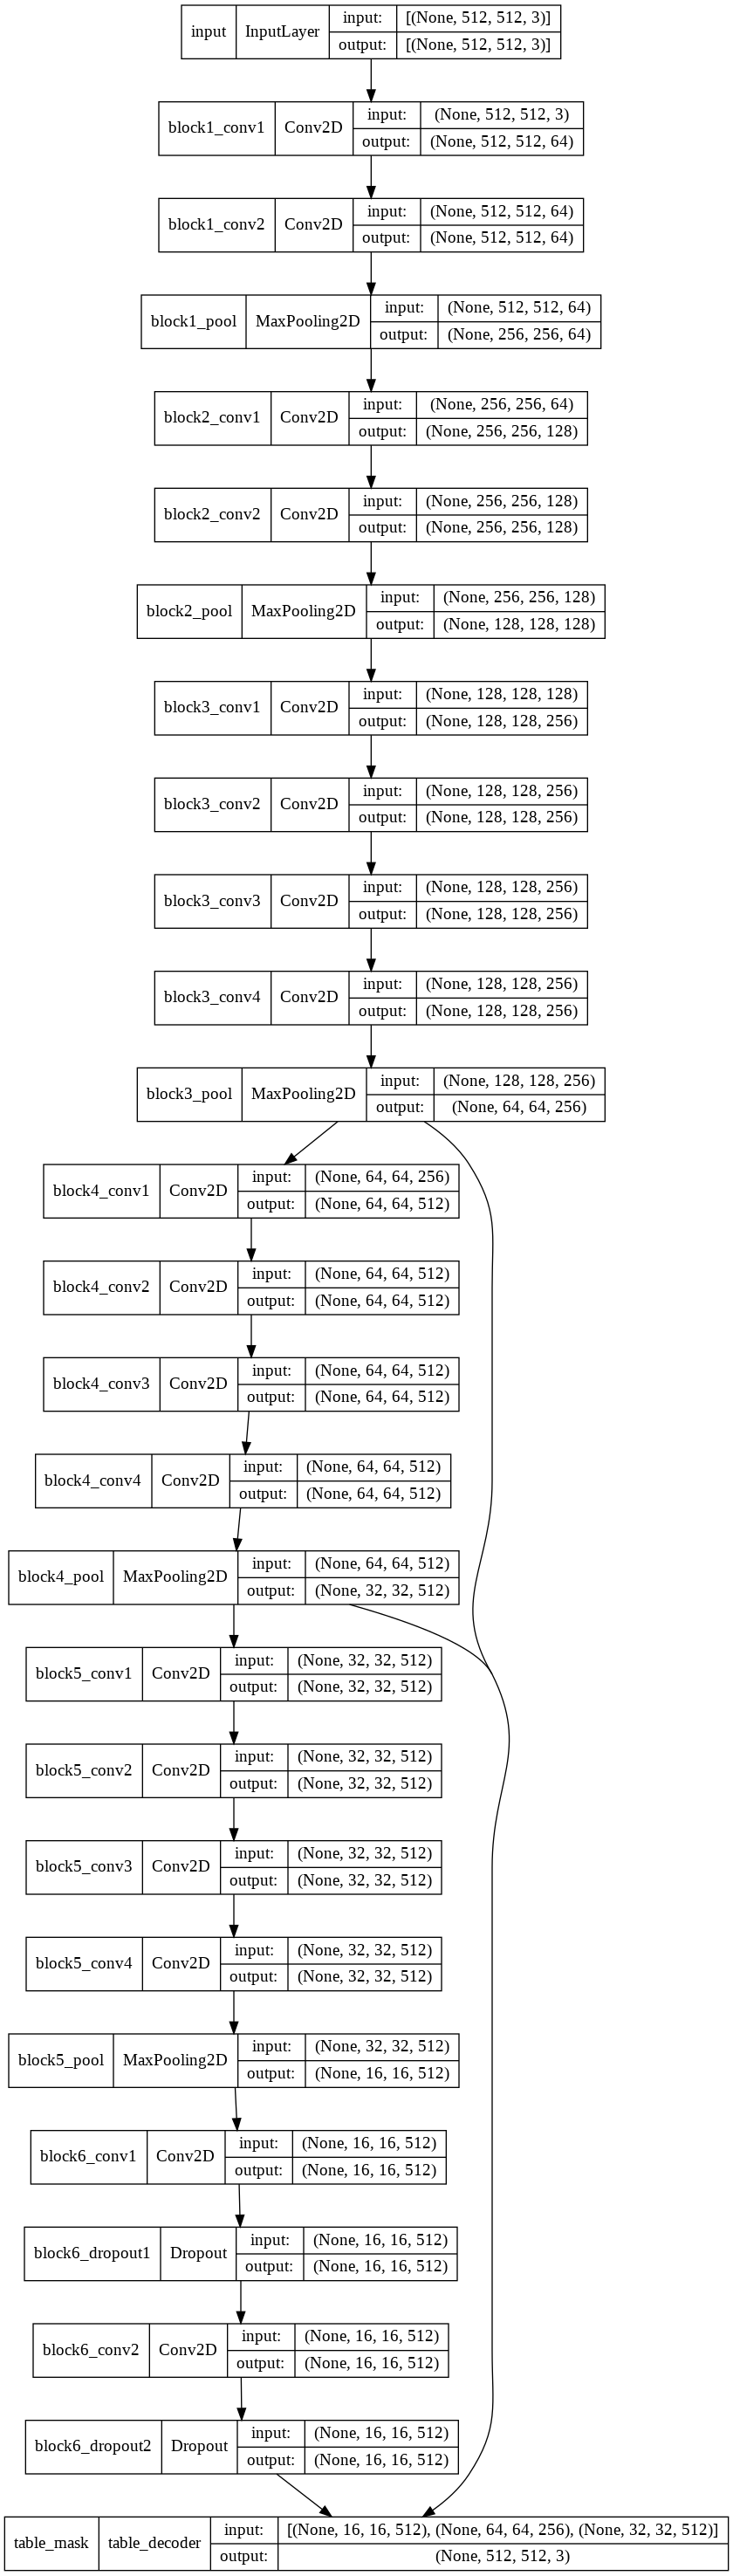

In [12]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)


In [13]:
model.summary()


Model: "tablenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

In [14]:
losses = {
    "table_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # "cell_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_mask": 1.0,
              #  "cell_mask": 1.0
               }

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-07),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

In [15]:
import datetime

curr = datetime.datetime.now()
print(str(curr).split('.')[0])
curr = str(curr).split('.')[0]
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/Fintab/"+curr+"/mymodel_best",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

2021-12-02 11:40:40


In [16]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Fintab/table 11-25 exp2 512x512 96.3/mymodel_best')

In [17]:
batch_size = 1
model_history = model.fit(train_dataloader, epochs=50,
                          steps_per_epoch=len(train_data)//batch_size,
                          validation_steps=len(test_data)//batch_size,
                          validation_data=test_dataloader, callbacks=[model_checkpoint,early_stopping]
                         )

Epoch 1/50
1847/1847 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9466
Epoch 00001: val_loss improved from inf to 0.11820, saving model to /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best/assets


1847/1847 [==============================] - 875s 144ms/step - loss: 0.1162 - accuracy: 0.9466 - val_loss: 0.1182 - val_accuracy: 0.9412
Epoch 2/50
1847/1847 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9522
Epoch 00002: val_loss did not improve from 0.11820
1847/1847 [==============================] - 253s 137ms/step - loss: 0.0907 - accuracy: 0.9522 - val_loss: 0.1241 - val_accuracy: 0.9473
Epoch 3/50
1847/1847 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9555
Epoch 00003: val_loss improved from 0.11820 to 0.10201, saving model to /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best/assets


1847/1847 [==============================] - 255s 138ms/step - loss: 0.0800 - accuracy: 0.9555 - val_loss: 0.1020 - val_accuracy: 0.9516
Epoch 4/50
1847/1847 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9589
Epoch 00004: val_loss improved from 0.10201 to 0.08281, saving model to /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best/assets


1847/1847 [==============================] - 251s 136ms/step - loss: 0.0674 - accuracy: 0.9589 - val_loss: 0.0828 - val_accuracy: 0.9560
Epoch 5/50
1847/1847 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9591
Epoch 00005: val_loss did not improve from 0.08281
1847/1847 [==============================] - 250s 135ms/step - loss: 0.0661 - accuracy: 0.9591 - val_loss: 0.0974 - val_accuracy: 0.9492
Epoch 6/50
1847/1847 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9626
Epoch 00006: val_loss did not improve from 0.08281
1847/1847 [==============================] - 233s 126ms/step - loss: 0.0564 - accuracy: 0.9626 - val_loss: 0.0894 - val_accuracy: 0.9535
Epoch 7/50
1847/1847 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9640
Epoch 00007: val_loss did not improve from 0.08281
1847/1847 [==============================] - 221s 120ms/step - loss: 0.0511 - accuracy: 0.9640 - val_loss: 0.0879 - val_accuracy: 0.9570
Epoch

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fintab/2021-12-02 11:40:40/mymodel_best/assets


1847/1847 [==============================] - 221s 119ms/step - loss: 0.0452 - accuracy: 0.9659 - val_loss: 0.0694 - val_accuracy: 0.9585
Epoch 9/50
1847/1847 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9666
Epoch 00009: val_loss did not improve from 0.06937
1847/1847 [==============================] - 222s 120ms/step - loss: 0.0431 - accuracy: 0.9666 - val_loss: 0.1051 - val_accuracy: 0.9544
Epoch 10/50
1847/1847 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9665
Epoch 00010: val_loss did not improve from 0.06937
1847/1847 [==============================] - 212s 115ms/step - loss: 0.0447 - accuracy: 0.9665 - val_loss: 0.1002 - val_accuracy: 0.9489
Epoch 11/50
1847/1847 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9687
Epoch 00011: val_loss did not improve from 0.06937
1847/1847 [==============================] - 216s 117ms/step - loss: 0.0374 - accuracy: 0.9687 - val_loss: 0.0769 - val_accuracy: 0.9585
Epo

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Fintab/2021-11-24 16:19:58/mymodel_21')

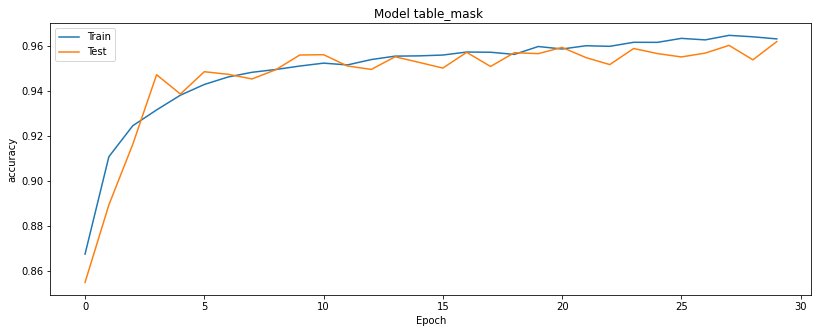

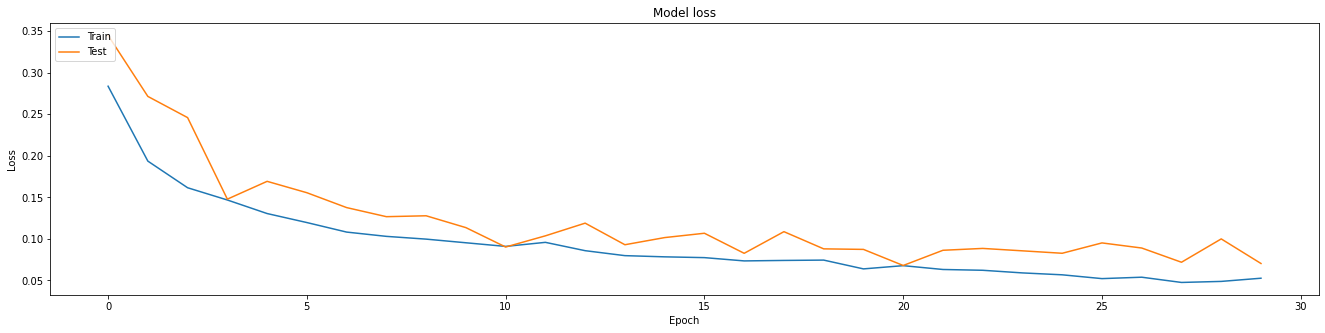

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
# plt.plot(model_history.history['table_mask_accuracy'])
# plt.plot(model_history.history['val_table_mask_accuracy'])
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model table_mask ')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# # Plot training & validation loss values
# plt.subplot(122)
# plt.plot(model_history.history['column_mask_accuracy'])
# plt.plot(model_history.history['val_column_mask_accuracy'])
# plt.title('Model column_mask')
# plt.ylabel('accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Plot training & validation loss values
plt.figure(figsize=(50, 5))
plt.subplot(122)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()